In [1]:
import os
import pandas as pd

In [2]:
ds = []
chars = 'abcdefghijklmnopqrstuvwxyz'
def directory_to_df(path : str):
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        cls_name = cls.split('_')[0]
        if not cls_name in chars:
            continue
    
        for image in os.listdir(cls_path):
            image_path = os.path.join(cls_path, image)
            ds.append([image_path, cls_name])
    
    df = pd.DataFrame(ds, columns=['image','label'])
    df.to_csv('/kaggle/working/metadata.csv')


main_path = '/kaggle/input/ocr-dataset/dataset' 
directory_to_df(main_path)



In [3]:
data = pd.read_csv("/kaggle/working/metadata.csv")
data.head()

,Unnamed: 0,image,label
0,0,/kaggle/input/ocr-dataset/dataset/c_L/C_L_1241...,c
1,1,/kaggle/input/ocr-dataset/dataset/c_L/C_L_3096...,c
2,2,/kaggle/input/ocr-dataset/dataset/c_L/C_L_3184...,c
3,3,/kaggle/input/ocr-dataset/dataset/c_L/C_L_2981...,c
4,4,/kaggle/input/ocr-dataset/dataset/c_L/C_L_1635...,c


In [4]:
X, y = data['image'], data['label']

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=41)

In [7]:
training_df = pd.concat((X_train,y_train), axis=1)
testing_df = pd.concat((X_test,y_test), axis=1)

In [8]:
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X,y , test_size=0.25, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
validation_df = pd.concat((X_valid,y_valid), axis=1)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Pre-defined hyperparameters
IMG_SHAPE = (32,32)
IMG_SIZE = (32,32,3)
BATCH_SIZE = 32


In [11]:
# Creating generators
gen = ImageDataGenerator(dtype=np.int32, brightness_range=[0.0,1.0], fill_mode='nearest')
gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE, 
                                   target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                        target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                       target_size=IMG_SHAPE, shuffle=False)

Found 44729 validated image filenames belonging to 26 classes.
Found 14910 validated image filenames belonging to 26 classes.
Found 25560 validated image filenames belonging to 26 classes.


In [12]:
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

In [13]:
def show_image(img, label=None) -> None:
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()

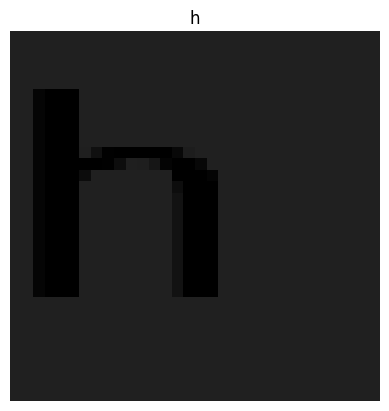

The shape of the image: (32, 32, 3)


In [14]:
BATCH_NUM = 10
IMG_NUM =2
 
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

In [15]:
len(mapping)

26

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense)

In [17]:
# Custom CNN
CNN_model = Sequential()
CNN_model.add(Input(shape=IMG_SIZE, batch_size=BATCH_SIZE, name='Input'))
CNN_model.add(Conv2D(3, (3,3), strides=1, activation='relu', padding='same'))
CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPool2D((3,3)))
CNN_model.add(Conv2D(256, (3,3), activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(256, (3,3), strides=2, activation='relu', padding='same'))
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(1024, (2,2), activation='relu', padding='same'))
CNN_model.add(MaxPool2D(2,2))
CNN_model.add(Flatten())
CNN_model.add(Dense(1024, activation='selu'))
CNN_model.add(Dense(len(mapping), activation='softmax'))

In [18]:
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (32, 32, 32, 3)        │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 30, 30, 128)      │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 10, 10, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 8, 8, 256)        │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 8, 8, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 4, 4, 256)        │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 2, 2, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 2, 2, 512)        │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 2, 2, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 2, 2, 1024)       │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 1, 1, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1024)             │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 26)               │        26,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,243,502 (20.00 MB)

 Trainable params: 5,243,502 (20.00 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.optimizers import Adam

In [20]:
opt = Adam(learning_rate=0.00001, epsilon=1e-6)
loss = 'categorical_crossentropy'
EPOCHS = 10

In [21]:
CNN_model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [23]:
def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'{model_name}_model.keras',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

In [24]:
history = CNN_model.fit(train_gen, epochs=2, validation_data=valid_gen, callbacks=clbck("CustomCnn"))

Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.2095 - loss: 3.1166
Epoch 1: val_loss improved from inf to 0.48680, saving model to CustomCnn_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 628s 447ms/step - accuracy: 0.2097 - loss: 3.1157 - val_accuracy: 0.8721 - val_loss: 0.4868 - learning_rate: 0.0010
Epoch 2/2
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8573 - loss: 0.5366
Epoch 2: val_loss improved from 0.48680 to 0.37860, saving model to CustomCnn_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 569s 406ms/step - accuracy: 0.8573 - loss: 0.5366 - val_accuracy: 0.9021 - val_loss: 0.3786 - learning_rate: 0.0010


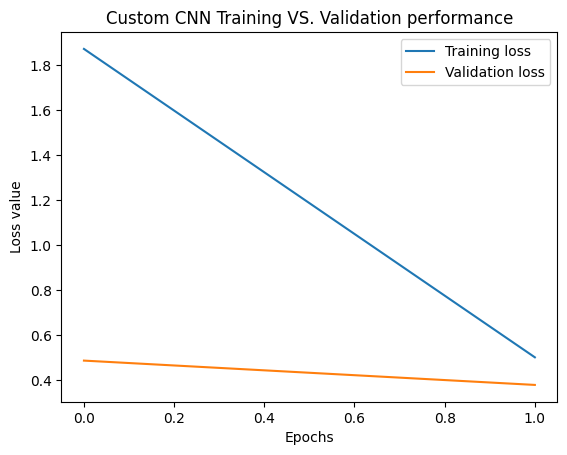

In [25]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("Custom CNN Training VS. Validation performance")
plt.show()

In [26]:
prediction = CNN_model.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

799/799 ━━━━━━━━━━━━━━━━━━━━ 83s 103ms/step


In [27]:
from sklearn.metrics import classification_report

In [28]:
print('\t\tThe Custom CNN Evaluation Performance')
print(classification_report(y_test, pred))

		The Custom CNN Evaluation Performance
              precision    recall  f1-score   support

           a       0.85      0.89      0.87       992
           b       0.89      0.93      0.91       929
           c       0.90      0.90      0.90      1008
           d       0.94      0.91      0.93       999
           e       0.89      0.83      0.86       973
           f       0.94      0.85      0.89      1000
           g       0.85      0.91      0.88       957
           h       0.89      0.93      0.91       973
           i       0.95      0.85      0.90       969
           j       0.91      0.94      0.92       931
           k       0.96      0.92      0.94      1000
           l       0.80      0.93      0.86       974
           m       0.94      0.92      0.93      1005
           n       0.85      0.89      0.87       951
           o       0.79      0.94      0.86       951
           p       0.93      0.92      0.92       982
           q       0.90      0.90      0.

In [29]:
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

In [30]:
train_layers = EfficientNetB7(include_top=False, input_shape=IMG_SIZE)
EffNetB7 = Sequential()
EffNetB7.add(train_layers)
EffNetB7.add(Flatten())
EffNetB7.add(Dense(1024, activation='selu'))
EffNetB7.add(Dropout(0.2))
EffNetB7.add(Dense(512, activation='selu'))
EffNetB7.add(Dense(len(mapping), activation='softmax'))

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [31]:
EffNetB7.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 63,786,960 (243.33 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [32]:
history2 = EffNetB7.fit(train_gen, epochs=2, validation_data=valid_gen, callbacks=clbck("EfficientNetB7"))

ValueError: You must call `compile()` before using the model.

In [ ]:
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("EfficientNetB7 Training VS. Validation performance")
plt.show()

In [ ]:
# The pre-defined optimizer will be used with too small learning rate
EffNetB7.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
# Making a prediction out of the EfficientNetB7 for the testing set for the evaluation
prediction = EffNetB7.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t     The EfficientNetB7 Evaluation Performance')
print(classification_report(y_test, pred))

In [ ]:
# MobileNetV2 input layers will not be FREEZED
train_layers = MobileNetV2(include_top=False, input_shape=IMG_SIZE)
MobNetV2 = Sequential()
MobNetV2.add(train_layers)
MobNetV2.add(Flatten())
MobNetV2.add(Dense(1024, activation='selu'))
MobNetV2.add(Dropout(0.2))
MobNetV2.add(Dense(512, activation='selu'))
MobNetV2.add(Dense(len(mapping), activation='softmax'))

In [ ]:
MobNetV2.summary()

In [ ]:
MobNetV2.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history3 = MobNetV2.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, callbacks=clbck('MobileNetV2'))

In [ ]:
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("MobileNetV2 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the MobileNetV2 for the testing set for the evaluation
prediction = MobNetV2.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t     The MobileNetV2 Evaluation Performance')
print(classification_report(y_test, pred))

In [ ]:
# VGG19 input layers will not be FREEZED
train_layers = VGG19(include_top=False, input_shape=IMG_SIZE)
VG = Sequential()
VG.add(train_layers)
VG.add(Flatten())
VG.add(Dense(1024, activation='selu'))
VG.add(Dense(512, activation='selu'))
VG.add(Dense(len(mapping), activation='softmax'))

In [ ]:
VG.summary()

In [ ]:
VG.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history4 = VG.fit(train_gen, validation_data=valid_gen, epochs=2, callbacks=clbck('VGG19'))

In [ ]:
plt.plot(history4.history['loss'], label='Training loss')
plt.plot(history4.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("VGG19 Training VS. Validation performance")
plt.show()

In [ ]:
prediction = VG.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t\tThe VGG19 Evaluation Performance')
print(classification_report(y_test, pred))

In [ ]:
train_layers = DenseNet121(include_top=False, input_shape=IMG_SIZE)
Den = Sequential()
Den.add(train_layers)
Den.add(Flatten())
Den.add(Dense(1024, activation='selu'))
Den.add(Dense(512, activation='selu'))
Den.add(Dense(len(mapping), activation='softmax'))

In [ ]:
Den.summary()

In [ ]:
Den.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history5 = Den.fit(train_gen, validation_data=valid_gen, epochs=2, callbacks=clbck("DenseNet121"))

In [ ]:
plt.plot(history5.history['loss'], label='Training loss')
plt.plot(history5.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("DenseNet121 Training VS. Validation performance")
plt.show()

In [ ]:
prediction = Den.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t\tThe DenseNet121 Evaluation Performance')
print(classification_report(y_test, pred))

In [ ]:
vals = {'accuracy':[0.95,0.93,0.71,0.96,0.95], 'precision':[0.96,0.94,0.72,0.96,0.95],
       'recall':[0.95,0.93,0.71,0.96,0.95], 'F1-Score':[0.95,0.93,0.71,0.96,0.95]}
results = pd.DataFrame(vals, index=['Custom CNN','EfficientNetB7','MobileNetV7','VGG19',
                                   'DenseNet121'])

print("\t\tThe Evaluation results of CNN/Pre-trained models")
print(results)

In [ ]:
import seaborn as sns

In [ ]:
sns.barplot(data=results, x=results.index, y='accuracy')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Accuracy")
plt.show()

In [ ]:
sns.barplot(data=results, x=results.index, y='precision')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Precision")
plt.show()

In [ ]:
sns.barplot(data=results, x=results.index, y='recall')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Recall")
plt.show()

In [ ]:
sns.barplot(data=results, x=results.index, y='F1-Score')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models F1-Score")
plt.show()

In [ ]:
import tensorflow as tf

In [ ]:
# Computer Vision - Low level techniques
def load_model():
    model_path = '/kaggle/working/DenseNet121_model.h5'
    model = tf.keras.saving.load_model(model_path)
    return model

def convert_2_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

def binarization(image):
    img, thresh = cv2.threshold(image, 0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words= False):
    img = image.copy()
    m = 3
    n = m - 2                   # n less than m for Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations = itrs)
    return dilation

def find_rect(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = []
    
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)  # Extract the bounding rectangle coordinates of each countour
        rects.append([x,y,w,h])
        
    sorted_rects = list(sorted(rects, key=lambda x: x[0])) # Sorting the rects from Left-to-Right
    return sorted_rects

def extract(image):
    model = load_model()
    chars = []              # a list to store recognized characters
    
    image_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img,words=True)
    words = find_rect(full_dil_img)                       # Recognized words within the image 
    del _, bin_img, full_dil_img                          # for better memory usage
    
    for word in words:
        x,y,w,h = word                                    # coordinates of the word
        img = image_cpy[y:y+h, x:x+w]
        
        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)                     # Recognized chars withtin the word
        cv2.rectangle(image, (x,y),(x+w,y+h), (0,255,0), 3) # draw a green rectangle around the word
        
        del _, bin_img, dil_img
        
        for char in char_parts:    
            x,y,w,h = char
            ch = img[y:y+h, x:x+w]
            
            empty_img = np.full((32,32,1),255, dtype=np.uint8) # a white image used for resize with filling
            x,y = 3,3                                          # starting indecies
            resized = cv2.resize(ch, (16,22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[y:y+22, x:x+16,0] = gray.copy()          # integrate the recognized char into the white image
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray = gray.astype(np.int32)
            
            predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
            chars.append(predicted)                            # append the character into the list
            
            del ch, resized, gray, empty_img
        chars.append(' ')  # at the end of each iteration (end of word) append a space
        
    del model
    show_image(image)
    return ''.join(chars[:-1])

In [ ]:
import cv2

In [ ]:
def read_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
# Testing 1
img = read_image('/kaggle/input/image-test/testt.png')
text = extract(img)
print('-->',text)

In [ ]:
# Testing 2
img2 = read_image('/kaggle/input/myimage15/Screenshot 2023-12-19 023610.png')
text = extract(img2)
print('-->',text)

In [ ]:
# Testing 3
img3 = read_image('/kaggle/input/myimage12/Screenshot 2023-12-19 021326.png')
text = extract(img3)
print('-->',text)

In [ ]:
# Testing 4
img4 = read_image('/kaggle/input/myimage8/Screenshot 2023-12-19 011000.png')
text = extract(img4)
print('-->',text)